In [5]:
import argparse
import sys

def parse_args():
    # 在 Jupyter 环境下，跳过 argparse 解析
    if 'ipykernel_launcher' in sys.argv[0]:
        sys.argv = sys.argv[:1]  # 只保留脚本名，不处理后续参数

    parser = argparse.ArgumentParser(description="Your script description")
    parser.add_argument('--outf', type=str, help="Output file path")
    args = parser.parse_args()
    return args

args = parse_args()
print(args)

Namespace(outf=None)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import argparse
from resnet import ResNet18
import os

# 定义是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 参数设置，使得我们能够手动输入命令行参数
parser = argparse.ArgumentParser(description="PyTorch CIFAR10 Training")
parser.add_argument(
    "--outf",
    default="./model/",
    help="Folder to output images and model checkpoints",
)  # 输出结果保存路径
args = parser.parse_args()

# 超参数设置
EPOCH = 135  # 遍历数据集次数
pre_epoch = 0  # 定义已经遍历数据集的次数
BATCH_SIZE = 128  # 批处理尺寸
LR = 0.01  # 学习率

# 准备数据集并预处理
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # 先四周填充0，再把图像随机裁剪成32*32
    transforms.RandomHorizontalFlip(),  # 图像一半的概率翻转，一半的概率不翻转
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # R,G,B每层的归一化用到的均值和方差
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 加载数据集
trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform_train
)  # 训练数据集
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)  # 生成一个个batch进行批训练

testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform_test
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2
)

# CIFAR-10的标签
classes = (
    "plane", "car", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
)

# 模型定义 - ResNet
net = ResNet18().to(device)

# 定义损失函数和优化方式
criterion = nn.CrossEntropyLoss()  # 损失函数为交叉熵，多用于多分类问题
optimizer = optim.SGD(
    net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4
)  # 优化方式为mini-batch momentum-SGD，并采用L2正则化

# 训练
if __name__ == "__main__":
    os.makedirs(args.outf, exist_ok=True)
    best_acc = 85  # 初始化best test accuracy
    print("Start Training, ResNet-18!")  # 定义遍历数据集的次数

    with open("acc.txt", "w") as f_acc, open("log.txt", "w") as f_log:
        for epoch in range(pre_epoch, EPOCH):
            print(f"\nEpoch: {epoch + 1}")
            net.train()
            sum_loss, correct, total = 0.0, 0.0, 0.0
            length = len(trainloader)

            for i, (inputs, labels) in enumerate(trainloader):
                # 准备数据
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                # forward + backward
                outputs = net(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # 每训练1个batch打印一次loss和准确率
                sum_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
                print(
                    f"[Epoch:{epoch + 1}, Iter:{i + 1 + epoch * length}] "
                    f"Loss: {sum_loss / (i + 1):.3f} | Acc: {100. * correct / total:.3f}%"
                )
                f_log.write(
                    f"{epoch + 1:03d}  {i + 1 + epoch * length:05d} | Loss: {sum_loss / (i + 1):.3f} | "
                    f"Acc: {100. * correct / total:.3f}%\n"
                )
                f_log.flush()

            # 每训练完一个epoch测试一下准确率
            print("Waiting Test!")
            with torch.no_grad():
                net.eval()
                correct, total = 0, 0
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = net(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()

                acc = 100. * correct / total
                print(f"测试分类准确率为：{acc:.3f}%")

                # 保存模型
                print("Saving model......")
                model_path = os.path.join(args.outf, f"net_{epoch + 1:03d}.pth")
                torch.save(net.state_dict(), model_path)
                f_acc.write(f"EPOCH={epoch + 1:03d}, Accuracy={acc:.3f}%\n")
                f_acc.flush()

                # 更新最佳准确率
                if acc > best_acc:
                    best_acc = acc
                    with open("best_acc.txt", "w") as f_best:
                        f_best.write(f"EPOCH={epoch + 1}, best_acc={best_acc:.3f}%")

        print(f"Training Finished, Total EPOCH={EPOCH}")

100%|██████████| 170498071/170498071 [3:36:52<00:00, 13102.60it/s]  


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Start Training, Resnet-18!

Epoch: 1
[Epoch:1, Iter:1] Loss: 2.418 | Acc: 13.281%
[Epoch:1, Iter:2] Loss: 2.363 | Acc: 14.062%
[Epoch:1, Iter:3] Loss: 2.340 | Acc: 13.802%
[Epoch:1, Iter:4] Loss: 2.315 | Acc: 15.039%
[Epoch:1, Iter:5] Loss: 2.311 | Acc: 13.750%
[Epoch:1, Iter:6] Loss: 2.293 | Acc: 14.583%
[Epoch:1, Iter:7] Loss: 2.277 | Acc: 14.286%
[Epoch:1, Iter:8] Loss: 2.251 | Acc: 15.234%
[Epoch:1, Iter:9] Loss: 2.226 | Acc: 16.059%
[Epoch:1, Iter:10] Loss: 2.207 | Acc: 17.031%
[Epoch:1, Iter:11] Loss: 2.201 | Acc: 17.259%
[Epoch:1, Iter:12] Loss: 2.186 | Acc: 17.773%
[Epoch:1, Iter:13] Loss: 2.174 | Acc: 18.750%
[Epoch:1, Iter:14] Loss: 2.158 | Acc: 19.587%
[Epoch:1, Iter:15] Loss: 2.156 | Acc: 19.948%
[Epoch:1, Iter:16] Loss: 2.131 | Acc: 20.898%
[Epoch:1, Iter:17] Loss: 2.137 | Acc: 20.726%
[Epoch:1, Iter:18] Loss: 2.129 | Acc: 21.267%
[Epoch:1, Iter:19] Loss: 2.115 | Acc: 21.587%
[Epoch:1,

Using device: cpu
Files already downloaded and verified
Model loaded successfully from ./model/net_077.pth


/var/folders/0v/_5zm56c954d9rkf7mx8z2zmw0000gn/T/ipykernel_60686/1339197834.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

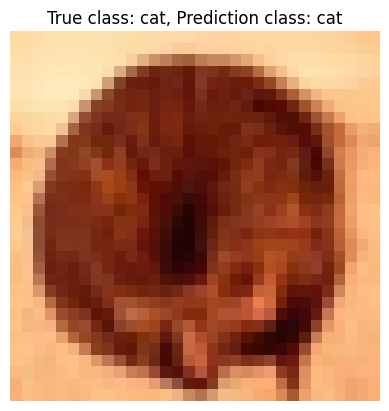

In [3]:
import os
import torch
import random
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from resnet import ResNet18  # 确保 ResNet18 定义在 resnet.py 文件中

# 定义设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 定义数据集的预处理（与训练时保持一致）
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# 加载测试数据集
testset = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# CIFAR-10 类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 加载模型
model_path = './model/net_077.pth'
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found: {model_path}")

model = ResNet18().to(device)
try:
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()  # 设置为评估模式
    print(f"Model loaded successfully from {model_path}")
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

# 随机选择一张测试图像
index = random.randint(0, len(testset) - 1)
image, true_label = testset[index]

# 数据需要扩展一个批次维度，并移动到设备上
image = image.unsqueeze(0).to(device)

# 进行预测
with torch.no_grad():
    output = model(image)
    _, predicted_label = torch.max(output, 1)

# 将图像数据转换回原始格式（取消归一化）
unnormalize = transforms.Normalize(
    mean=[-0.4914 / 0.2023, -0.4822 / 0.1994, -0.4465 / 0.2010],
    std=[1 / 0.2023, 1 / 0.1994, 1 / 0.2010]
)
image = unnormalize(image.squeeze(0).cpu()).numpy().transpose((1, 2, 0))
image = (image - image.min()) / (image.max() - image.min())  # 将像素值归一化到 [0, 1]

# 显示图像及其预测结果
plt.imshow(image)
plt.title(f"True class: {classes[true_label]}, Prediction class: {classes[predicted_label.item()]}")
plt.axis('off')
plt.show()